"Shadows cast by vegetation and structures add significant noise to imagery at one meter resolution. Shadows typically appear at the edges of tall buildings and trees, and mottled within tree canopies, and are commonly misclassified as water or impervious surface. Using a binary step of classifying vegetation versus non-vegetation reduced these errors."

https://www.epa.gov/sites/production/files/2015-11/documents/baynes_esri_landcover_120313.pdf

In [1]:
import time
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [100]:
data_filepath = str(u"C:\\Users\\Alison Link\\Documents\\INET4710\\FinalProjectData\\naip")

train_images = [
    data_filepath + u'\\2015\\twincities\\m_4409307_ne_15_1_20150927_20151221.tif' # just west of downtown St. Paul (by St. Paul campus)
]

test_images = [
    data_filepath + u'\\2015\\twincities\\m_4409306_ne_15_1_20150930_20151221.tif', # downtown Minneapolis
    data_filepath + u'\\2015\\twincities\\m_4409307_nw_15_1_20150927_20151221.tif', # just east of downtown Minneapolis
    data_filepath + u'\\2015\\twincities\\m_4409308_nw_15_1_20150927_20151221.tif', # downtown St. Paul
    data_filepath + u'\\2015\\duluth\\m_4609215_se_15_1_20150922_20151221.tif', # Duluth north w/ some lake
    data_filepath + u'\\2015\\duluth\\m_4609223_nw_15_1_20150922_20151221.tif', # Duluth w/ some lake
    data_filepath + u'\\2015\\duluth\\m_4609216_sw_15_1_20150922_20151221.tif' # Duluth downtown w/ lots of lake
]

## NDVI

https://gisgeography.com/ndvi-normalized-difference-vegetation-index/

https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-in-python/vegetation-indices-NDVI-in-python/ - GOOD article!

https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-calculations.html

In [109]:
def visualize_ndvi(img_filepath):
    
    np.seterr(divide='ignore', invalid='ignore')
    
    img = rasterio.open(img_filepath)
    band_r = img.read(1).astype(float)
    band_ir = img.read(4).astype(float)
    
    #check = np.logical_or( band_r > 0, band_ir > 0 )
    #ndvi = np.where(check & ((band_ir - band_r) / (band_ir + band_r) > 0), 1, 0 )
    #show_hist(ndvi, bins=50)
    
    ndvi = np.empty(img.shape, dtype=rasterio.float32)
    ndvi = (band_ir - band_r) / (band_ir + band_r)

    ndvi_neg1 = np.empty(img.shape, dtype=rasterio.float32)
    ndvi_neg1 = np.where(np.logical_and(np.greater_equal((band_ir - band_r) / (band_ir + band_r), -0.3),
                                        np.less_equal((band_ir - band_r) / (band_ir + band_r), 0)), 1, 0)
    
    ndvi_neg2 = np.empty(img.shape, dtype=rasterio.float32)
    ndvi_neg2 = np.where(((band_ir - band_r) / (band_ir + band_r)) < -0.3, 1, 0)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(21,7))
    
    show_hist(ndvi, bins=50, ax=ax1)
    ax2.imshow(ndvi, cmap='viridis')
    ax2.set_title('NDVI +/-')
    
    ax3.imshow(ndvi_neg1)
    ax3.set_title('NDVI - (non-water)')
    ax4.imshow(ndvi_neg2)
    ax4.set_title('NDVI - (water)')

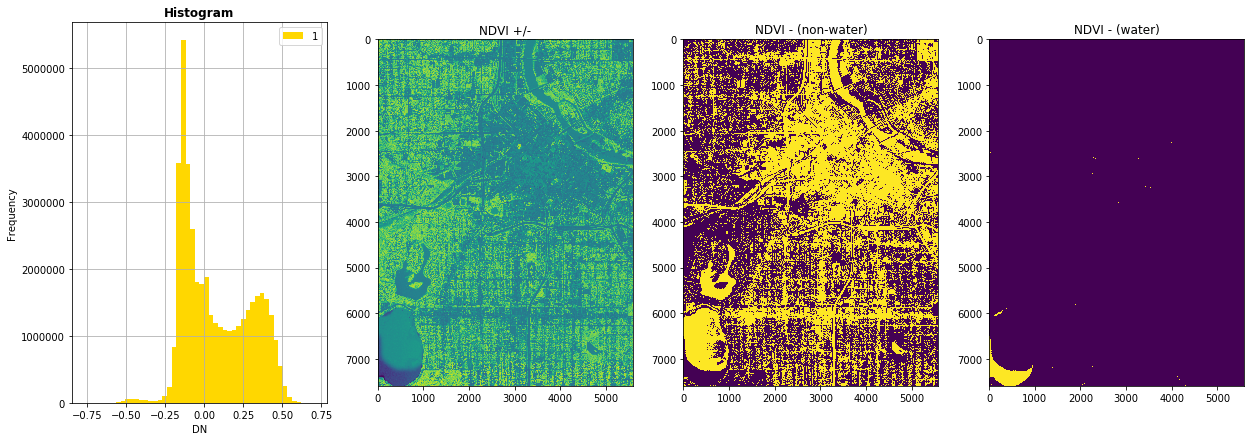

In [110]:
visualize_ndvi(test_images[0])

## NDWI

In [17]:
def visualize_ndwi(img_filepath):
    
    np.seterr(divide='ignore', invalid='ignore')
    
    img = rasterio.open(img_filepath)
    band_g = img.read(2).astype(float)
    band_ir = img.read(4).astype(float)
    
    #check = np.logical_or( band_r > 0, band_ir > 0 )
    #ndvi = np.where(check & ((band_ir - band_r) / (band_ir + band_r) > 0), 1, 0 )
    #show_hist(ndvi, bins=50)
    
    ndwi = np.empty(img.shape, dtype=rasterio.float32)
    ndwi = (band_g - band_ir) / (band_g + band_ir)
    
    ndwi_pos = np.empty(img.shape, dtype=rasterio.float32)
    ndwi_pos = np.where(((band_g - band_ir) / (band_g + band_ir)) > 0.3, 1, 0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,7))
    
    show_hist(ndwi, bins=50, ax=ax1)
    ax2.imshow(ndwi, cmap='viridis')
    ax3.imshow(ndwi_pos)

In [ ]:
visualize_ndwi(test_images[2])

## Image reshaping

In [42]:
def make_img_long(img_filepath, compute_ndvi=False):
    start = time.time()
    
    dataset = rasterio.open(img_filepath)
    img_metadata = dataset.meta.copy() # need to make a copy of this so we're not manipulating it in place
    img_3darray = dataset.read()
    
    # Save height and width values so we can reconstruct the image later
    height = img_3darray.shape[1] 
    width = img_3darray.shape[2]
    
    # Convert raster to list, then to dataframe
    # See: https://gis.stackexchange.com/questions/32995/how-to-fully-load-a-raster-into-a-numpy-array
    img_list = img_3darray.transpose(1, 2, 0).reshape(-1, 4).astype(float)
    out_df = pd.DataFrame(data=img_list)
    
    if compute_ndvi:
        print("Computing NDVI")
        
        # NDVI = (IR band - red band) / (IR band + red band)
        # See: https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-in-python/vegetation-indices-NDVI-in-python/
        def ndvi_func(bands):
            #print(bands)
            #print(str(bands[0]) + " : " + str(bands[3]))
            if (bands[1] + bands[4]) > 0:
                ndvi = (bands[4] - bands[1]) / (bands[4] + bands[1])
                #print(ndvi)
                if ndvi > 0:
                    return(ndvi)
                else:
                    return(ndvi)
            else:
                return(0)
        
        out_df['ndvi'] = [ndvi_func(row) for row in out_df.itertuples()]
    
    stop = time.time()
    runtime = round(stop - start, 3)
    print("Transformed image to dataframe in " + str(runtime) + " seconds.")
    return(out_df, img_metadata)

In [5]:
train_img_df, train_img_metadata = make_img_long(train_images[0], compute_ndvi=True)

Computing NDVI
Transformed image to dataframe in 60.667 seconds.


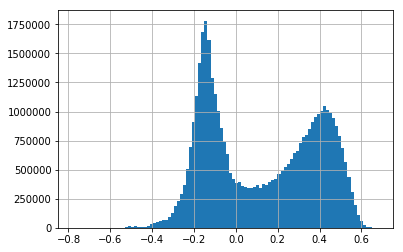

In [5]:
train_img_df['ndvi'].hist(bins=100)
print(min(train_img_df['ndvi']))

In [84]:
test_img_df, test_img_metadata = make_img_long(test_images[2], compute_ndvi=True)

Computing NDVI
Transformed image to dataframe in 67.144 seconds.


-0.7777777777777778


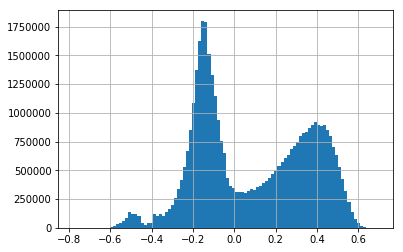

In [85]:
test_img_df['ndvi'].hist(bins=100)
print(min(test_img_df['ndvi']))

## Train Bifurcated Model Based on Positive/Negative NDVI w/ Water Separated Out

In [103]:
from sklearn.decomposition import NMF
import joblib # for saving models

def fit_ndvi_segmented_nmf(model_name, img_df_long, img_metadata, mode = "train",
                           ndvi_water_cutoff = -0.35, ndvi_pos_components=2, ndvi_neg_components=2, 
                           save_to_file=False, filename= ""):
    
    # Get pixels that are obviously water
    ndvi_water_pixels = img_df_long.loc[img_df_long['ndvi'] <= ndvi_water_cutoff]
    
    # Get pixels where NDVI value is > 0
    ndvi_pos_pixels = img_df_long.loc[img_df_long['ndvi'] > 0]
    
    # Get pixels where NDVI value is < 0
    ndvi_neg_pixels = img_df_long.loc[(img_df_long['ndvi'] > ndvi_water_cutoff) & (img_df_long['ndvi'] <= 0)]

    if mode == "train":
        # Fit NDVI positive model 
        start1 = time.time()
        ndvi_pos_model = NMF(n_components=ndvi_pos_components, init='random', random_state=0)
        ndvi_pos_model_W = ndvi_pos_model.fit_transform(ndvi_pos_pixels[[0, 1, 2, 3]]) # Pass only the 4-band pixel values to train one
        ndvi_pos_model_H = ndvi_pos_model.components_
        stop1 = time.time()
        runtime1 = round(stop1 - start1, 3)
        print("NDVI Positive Model completed in " + str(runtime1) + " seconds.")
        # Save the model for future use
        joblib.dump(ndvi_pos_model, './models/{}_NMF_{}pos_classes.joblib'.format(model_name, ndvi_pos_components)) 

        # Fit NDVI negative model
        start2 = time.time()
        ndvi_neg_model = NMF(n_components=ndvi_neg_components, init='random', random_state=0)
        ndvi_neg_model_W = ndvi_neg_model.fit_transform(ndvi_neg_pixels[[0, 1, 2, 3]])
        ndvi_neg_model_H = ndvi_neg_model.components_
        stop2 = time.time()
        runtime2 = round(stop2 - start2, 3)
        print("NDVI Negative Model completed in " + str(runtime2) + " seconds.")
        # Save the model for future use
        joblib.dump(ndvi_neg_model, './models/{}_NMF_{}neg_classes.joblib'.format(model_name, ndvi_neg_components))
    
    if mode == "test":
        print("Fitting positive/negative NDVI models to test data...")
        # Load models from file, then fit
        start = time.time()
        ndvi_pos_model = joblib.load('./models/{}_NMF_{}pos_classes.joblib'.format(model_name, ndvi_pos_components))
        ndvi_pos_model_W = ndvi_pos_model.transform(ndvi_pos_pixels[[0, 1, 2, 3]])
    
        ndvi_neg_model = joblib.load('./models/{}_NMF_{}neg_classes.joblib'.format(model_name, ndvi_neg_components))
        ndvi_neg_model_W = ndvi_neg_model.transform(ndvi_neg_pixels[[0, 1, 2, 3]])
        
        stop = time.time()
        runtime = round(stop - start, 3)
        print("Models fit to test data in " + str(runtime) + " seconds.")
    
    # Classify using argmax to get the category with the highest weight for each pixel
    ndvi_water_pixels['category'] = 0 # assign water pixels to category=0
    ndvi_pos_pixels['category'] = np.argmax(ndvi_pos_model_W, axis=1) + 1 # offset category number by 1 to leave room for water class
    ndvi_neg_pixels['category'] = np.argmax(ndvi_neg_model_W, axis=1) + 1 + ndvi_pos_components # make sure our category values don't overlap
    
    # Recombine dataframe by appending everything together, then sort on the index put pixels back in order
    out_df = ndvi_water_pixels.append(ndvi_pos_pixels)
    out_df = out_df.append(ndvi_neg_pixels).sort_index()
    
    # Take the categorized data and coerce into a numpy array that's in the shape of the original images
    out_img = np.reshape(np.array(out_df['category']), (img_metadata['height'], img_metadata['width']))
    
    if save_to_file:
        img_metadata.update({
            'count': 1, # we now only have a single-band image containing integer classifications
            'dtype': rasterio.uint8
        })
        
        filename = './classified_images/{}_{}pos_{}neg_{}.tif'.format(model_name, ndvi_pos_components, ndvi_neg_components, filename)
        # Save classified data to a GeoTIFF file
        with rasterio.open(filename, "w", **img_metadata) as dest:
            dest.write(out_img.astype(rasterio.uint8), 1)
    else:
        # Only return values if we haven't saved the results to a file; this takes up space in memory, 
        # so returning results in this way is not recommended for batch processing
        return(out_df, out_img) 

In [104]:
fit_ndvi_segmented_nmf('StPaulCampus', train_img_df, train_img_metadata, mode = "train",
                       ndvi_neg_components = 3, ndvi_pos_components = 3, ndvi_water_cutoff = -0.3,
                       save_to_file = True, filename = 'TRAIN')

NDVI Positive Model completed in 325.177 seconds.
NDVI Negative Model completed in 253.557 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [89]:
fit_ndvi_segmented_nmf('StPaulCampus', test_img_df, test_img_metadata, mode = "test",
                       ndvi_neg_components = 3, ndvi_pos_components = 3 
                       #save_to_file = True,
                       #filename = 'TEST2'
                      )

Fitting positive/negative NDVI models to test data...
Models fit to test data in 174.906 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Train/Test Workflow

In [102]:
# Fit model to test images
for i in range(len(test_images)):
    print("Fitting image " + str(i) + "...")
    
    # Convert the img to a list format
    test_img_df, test_img_metadata = make_img_long(test_images[i], compute_ndvi=True) 
    
    # Run the model and save the results to a file
    filename_to_save = 'TEST' + str(i)
    fit_ndvi_segmented_nmf('StPaulCampus', test_img_df, test_img_metadata, mode = "test",
                           ndvi_neg_components = 5, ndvi_pos_components = 5, 
                           save_to_file = True, filename = filename_to_save)

Fitting image 0...
Computing NDVI
Transformed image to dataframe in 59.712 seconds.
Fitting positive/negative NDVI models to test data...
Models fit to test data in 420.085 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting image 1...
Computing NDVI
Transformed image to dataframe in 61.292 seconds.
Fitting positive/negative NDVI models to test data...
Models fit to test data in 419.769 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting image 2...
Computing NDVI
Transformed image to dataframe in 60.739 seconds.
Fitting positive/negative NDVI models to test data...
Models fit to test data in 426.725 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting image 3...
Computing NDVI
Transformed image to dataframe in 59.456 seconds.
Fitting positive/negative NDVI models to test data...
Models fit to test data in 445.817 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting image 4...
Computing NDVI
Transformed image to dataframe in 60.004 seconds.
Fitting positive/negative NDVI models to test data...
Models fit to test data in 523.637 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting image 5...
Computing NDVI
Transformed image to dataframe in 60.766 seconds.
Fitting positive/negative NDVI models to test data...
Models fit to test data in 235.572 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Visualize & Save Classified Images

In [80]:
def display_categorized_img(categorized_img, num_pos_classes, num_neg_classes):
    from matplotlib import colors
    
    # Pick colors from preset lists based on pos/neg NDVI classes
    pos_colors = ['maroon', 'red', 'pink']
    neg_colors = ['lightgreen', 'lime', 'darkgreen']
    
    # Concatenate into a colors list, with blue always coming first because it corresponds to class=0
    colors_list = ['blue'] + neg_colors[0:(num_neg_classes)] + pos_colors[0:(num_pos_classes)]
  
    # Visualize the pixel categories
    fig = plt.figure(figsize=(15, 15))
    #colors = ListedColormap(('#14565A', '#E3B537', '#D83F2B', '#65CB11', '#ffffff', '#0E83C2'), name='custom')
    #colors = ListedColormap(['red', 'yellow', 'green', 'blue', 'purple', 'black', 'fuchsia', 'cyan', 'gray', 'white', 'orange', 'pink'])
    colors = colors.ListedColormap(colors_list)
    image = plt.imshow(categorized_img, cmap=colors)
    plt.colorbar(image)

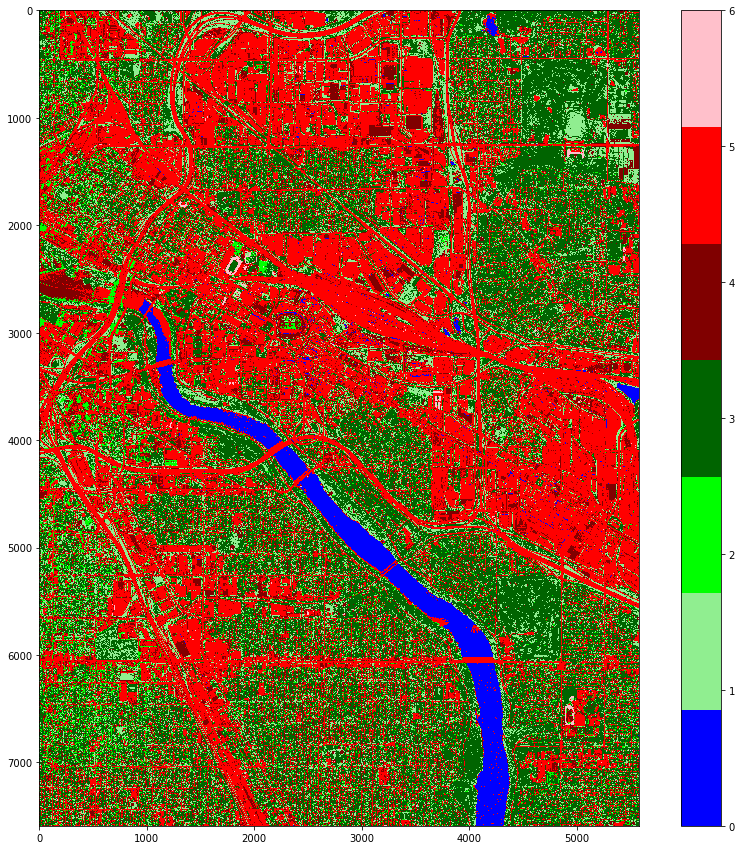

In [81]:
display_categorized_img(classified_test_img_array, 3, 3)

In [69]:
def save_img_to_disk(img_array, img_metadata, filename):
    img_metadata.update({
        'count': 1, # we now only have a single-band image containing integer classifications
        'dtype': rasterio.uint8
    })

    # Save classified data to a GeoTIFF file
    with rasterio.open(filename, "w", **img_metadata) as dest:
        dest.write(img_array.astype(rasterio.uint8), 1)

In [73]:
train_img_metadata

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 5570,
 'height': 7580,
 'crs': CRS.from_dict(init='epsg:26915'),
 'transform': Affine(1.0, 0.0, 484890.0,
        0.0, -1.0, 4983280.0),
 'count': 1}

In [71]:
classified_train_img_array.shape

(7580, 5570)

In [82]:
save_img_to_disk(classified_test_img_array, test_img_metadata, "./classified_images/StPaulCampus_3pos_3neg_TEST1.tif")

# Junk

In [78]:
def separate_and_recombine_ndvi_dfs(train_img_df, size):
    ndvi_pos_pixels = train_img_df.loc[train_img_df['ndvi_pos']]
    ndvi_neg_pixels = train_img_df.loc[~train_img_df['ndvi_pos']]
    
    ndvi_pos_pixels['category'] = 1
    ndvi_neg_pixels['category'] = 0
    out_df = ndvi_pos_pixels.append(ndvi_neg_pixels).sort_index()
    out_img = np.reshape(np.array(out_df['category']), size)
    return(out_df, out_img)

out_df, out_img = separate_and_recombine_ndvi_dfs(train_img_df, (train_img_height, train_img_width))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [317]:
import joblib

def classify_test_image(img_df, img_metadata, 
                        ndvi_pos_model_filepath, ndvi_neg_model_filepath, 
                        ndvi_water_cutoff = -0.35, ndvi_pos_components = 2, ndvi_neg_components = 2):
    
    # Get pixels that are obviously water
    ndvi_water_pixels = img_df.loc[img_df['ndvi'] <= ndvi_water_cutoff]
    
    # Get pixels where NDVI value is > 0
    ndvi_pos_pixels = img_df.loc[img_df['ndvi'] > 0]
    
    # Get pixels where NDVI value is < 0
    ndvi_neg_pixels = img_df.loc[(img_df['ndvi'] > ndvi_water_cutoff) & (img_df['ndvi'] <= 0)]
    
    start = time.time()
    
    # Load models from file, then fit
    ndvi_pos_model = joblib.load(ndvi_pos_model_filepath)
    ndvi_pos_model_W = ndvi_pos_model.transform(ndvi_pos_pixels[[0, 1, 2, 3]])
    
    ndvi_neg_model = joblib.load(ndvi_neg_model_filepath)
    ndvi_neg_model_W = ndvi_neg_model.transform(ndvi_neg_pixels[[0, 1, 2, 3]])
    
    stop = time.time()
    runtime = round(stop - start, 3)
    print("Models fit to test data in " + str(runtime) + " seconds.")
    
    # Classify
    ndvi_water_pixels['category'] = 0 # assign water pixels to category=0
    ndvi_pos_pixels['category'] = np.argmax(ndvi_pos_model_W, axis=1) + 1
    ndvi_neg_pixels['category'] = np.argmax(ndvi_neg_model_W, axis=1) + 1 + ndvi_pos_components # make sure our category values don't overlap
    
    # Recombine dataframe
    out_df = ndvi_water_pixels.append(ndvi_pos_pixels)
    out_df = out_df.append(ndvi_neg_pixels).sort_index() # recombine into single df, then put pixels back in order
    out_img = np.reshape(np.array(out_df['category']), (test_img_metadata['height'], test_img_metadata['width'])) # take the new categories and coerce into a numpy array that's in the shape of the original image
    
    return(out_df, out_img)  

In [322]:
classified_test_img_df, classified_test_img_array = classify_test_image(test_img_df, test_img_metadata,
                                                                        './models/NMF_2pos_components_MplsEast_with_water.joblib',
                                                                        './models/NMF_2neg_components_MplsEast_with_water.joblib'
                                                                       )

Models fit to test data in 21.156 seconds.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


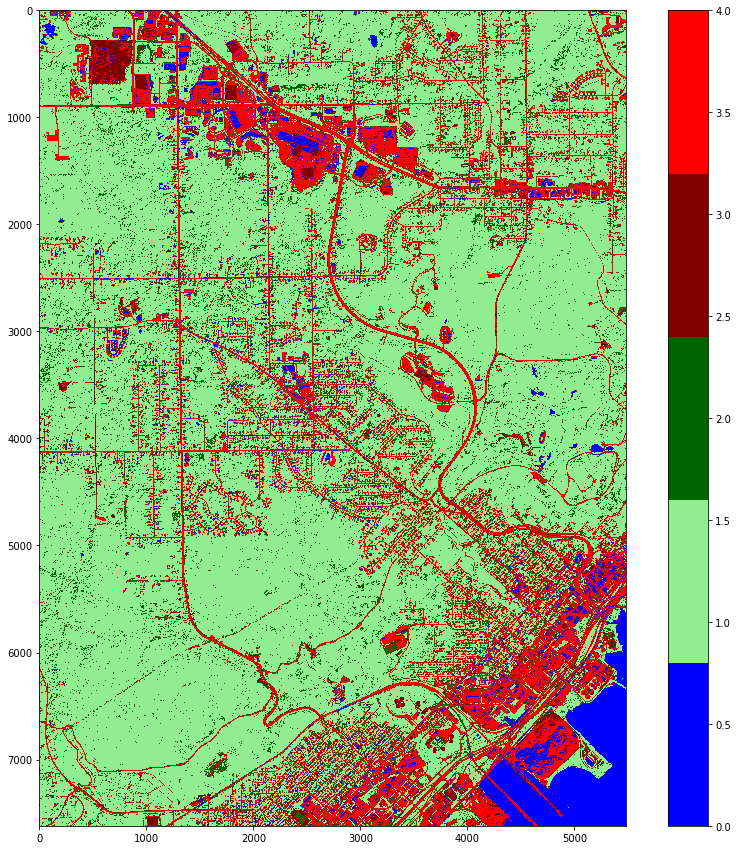

In [323]:
display_categorized_img(classified_test_img_array)

## Train Bifurcated Model

In [206]:
from sklearn.decomposition import NMF
import joblib

def train_ndvi_bifurcated_nmf(train_img_df, size, ndvi_pos_components=2, ndvi_neg_components=2):
    
    # Get pixels where NDVI value is > 0
    ndvi_pos_pixels = train_img_df.loc[train_img_df['ndvi'] > 0]
    
    # Get pixels where NDVI value is < 0
    ndvi_neg_pixels = train_img_df.loc[train_img_df['ndvi'] <= 0]

    start1 = time.time()
    ndvi_pos_model = NMF(n_components=ndvi_pos_components, init='random', random_state=0)
    ndvi_pos_model_W = ndvi_pos_model.fit_transform(ndvi_pos_pixels[[0, 1, 2, 3]]) # Pass only the 4-band pixel values to train one
    ndvi_pos_model_H = ndvi_pos_model.components_
    stop1 = time.time()
    runtime1 = round(stop1 - start1, 3)
    print("NDVI Positive Model completed in " + str(runtime1) + " seconds.")
    
    # Save the model for future use
    joblib.dump(ndvi_pos_model, './models/NMF_{}pos_components_MplsEast.joblib'.format(ndvi_pos_components)) 
    
    start2 = time.time()
    ndvi_neg_model = NMF(n_components=ndvi_neg_components, init='random', random_state=0)
    ndvi_neg_model_W = ndvi_neg_model.fit_transform(ndvi_neg_pixels[[0, 1, 2, 3]])
    ndvi_neg_model_H = ndvi_neg_model.components_
    stop2 = time.time()
    runtime2 = round(stop2 - start2, 3)
    print("NDVI Negative Model completed in " + str(runtime2) + " seconds.")
    
    # Save the model for future use
    joblib.dump(ndvi_neg_model, './models/NMF_{}neg_components_MplsEast.joblib'.format(ndvi_neg_components))
    
    # Classify
    ndvi_pos_pixels['category'] = np.argmax(ndvi_pos_model_W, axis=1)
    ndvi_neg_pixels['category'] = np.argmax(ndvi_neg_model_W, axis=1) + ndvi_pos_components # make sure our category values don't overlap
    
    # Recombine dataframe
    out_df = ndvi_pos_pixels.append(ndvi_neg_pixels).sort_index() # recombine into single df, then put pixels back in order
    out_img = np.reshape(np.array(out_df['category']), size) # take the new categories and coerce into a numpy array that's in the shape of the original images
    
    return(out_df, out_img)   

In [207]:
classified_img_df, classified_img = train_ndvi_bifurcated_nmf(train_img_df, (train_img_height, train_img_width))

[[102.0251046  100.47111111 110.68807339 107.24444444 123.09684349]
 [ 49.94979079  42.89777778  41.94495413  84.66666667 152.44507141]
 [ 39.32217573  45.15555556  43.11009174 101.6        178.16492562]
 ...
 [114.77824268 120.79111111  79.2293578  197.55555556 160.35571592]
 [111.58995816 120.79111111  78.06422018 197.55555556 162.26016898]
 [107.33891213 117.40444444  75.73394495 197.55555556 164.858297  ]]


ValueError: not enough values to unpack (expected 2, got 0)

In [187]:
classified_img_df['category'].value_counts()

3    17221369
0    15127315
1     5528589
2     4474927
Name: category, dtype: int64

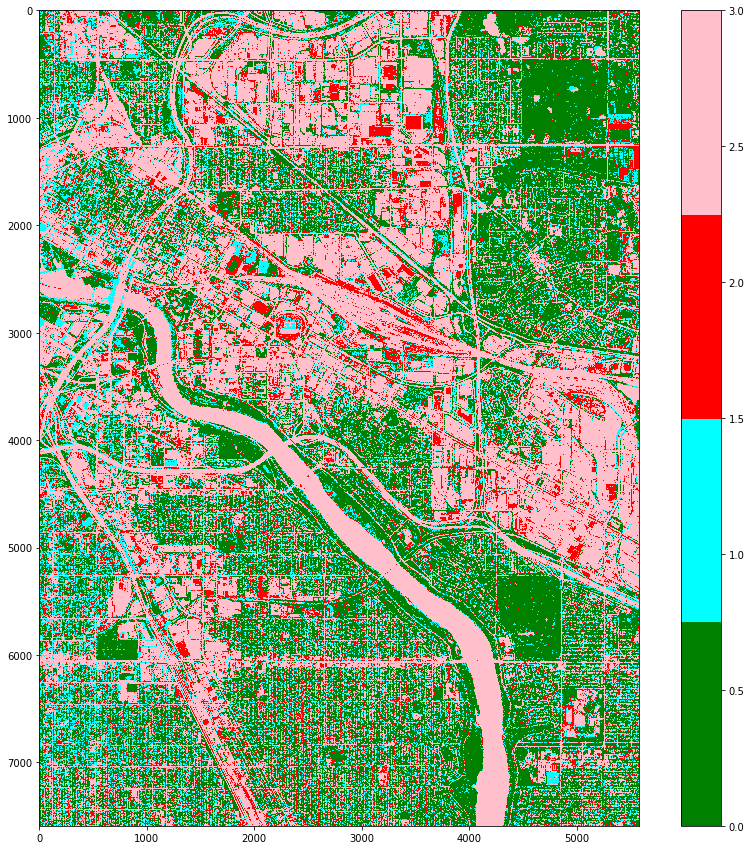

In [189]:
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
#cmap = colors.ListedColormap(['green', 'cyan', 'darkgreen', 'lightgreen', 'red', 'pink', 'orange', 'fuchsia'])
cmap = colors.ListedColormap(['green', 'cyan', 'red', 'pink'])
image = plt.imshow(classified_img, cmap=cmap)
plt.colorbar(image)

## Train scaled model using NDVI as input

In [208]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0, 254))
scaled_df = scaler.fit_transform(train_img_df)

start = time.time()

model = NMF(n_components=6, init='random', random_state=0) # Takes ~25 min to run
W = model.fit_transform(scaled_df)
H = model.components_

stop = time.time()
runtime = round(stop - start, 3)
print("Model completed in " + str(runtime) + " seconds.")

Model completed in 1554.765 seconds.


In [223]:
scaled_df[0:1000]

array([[123.28033473, 118.53333333, 130.49541284, 107.24444444,
        109.84829162],
       [102.0251046 , 100.47111111, 110.68807339, 107.24444444,
        123.09684349],
       [ 49.94979079,  42.89777778,  41.94495413,  84.66666667,
        152.44507141],
       ...,
       [114.77824268, 120.79111111,  79.2293578 , 197.55555556,
        160.35571592],
       [111.58995816, 120.79111111,  78.06422018, 197.55555556,
        162.26016898],
       [107.33891213, 117.40444444,  75.73394495, 197.55555556,
        164.858297  ]])

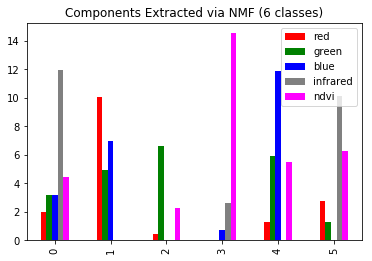

In [218]:
components_df = pd.DataFrame({'red': H[:,0], 'green': H[:,1], 'blue': H[:,2], 'infrared': H[:,3], 'ndvi': H[:,4]})

colors = ListedColormap(['red', 'green', 'blue', 'gray', 'fuchsia'])
components_df.plot(kind='bar', cmap=colors, title='Components Extracted via NMF (6 classes)')

In [209]:
pixel_categories = np.argmax(W, axis=1)

In [214]:
def display_categorized_img(categorized_pixel_list, size):
    ''' Take the set of pixels that has been transformed into a "long" dataset, 
    and convert it back to an image with the original dimensions '''
    categorized_img = np.reshape(categorized_pixel_list, size)

    # Visualize the pixel categories
    fig = plt.figure(figsize=(15, 15))
    #colors = ListedColormap(('#14565A', '#E3B537', '#D83F2B', '#65CB11', '#ffffff', '#0E83C2'), name='custom')
    #colors = ListedColormap(['red', 'yellow', 'green', 'blue', 'purple', 'black', 'fuchsia', 'cyan', 'gray', 'white', 'orange', 'pink'])
    colors = ListedColormap(['green', 'red', 'black', 'cyan', 'white', 'yellow'])
    image = plt.imshow(categorized_img, cmap=colors)
    plt.colorbar(image)
    
display_categorized_img(pixel_categories, (train_img_height, train_img_width))

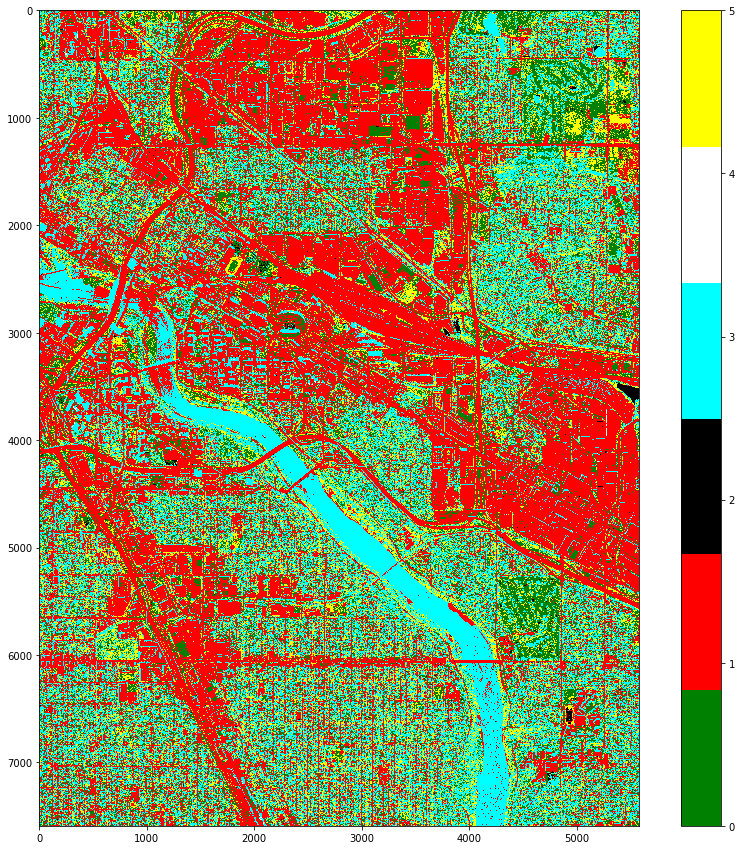

In [216]:
import joblib
joblib.dump(model, './models/NMF_6components_MplsEast_scaled_w_ndvi_as_input.joblib')

['./models/NMF_6components_MplsEast_scaled_w_ndvi_as_input.joblib']

%reset